In [ ]:
#!pip install torch
#!pip install transformers==3.5
#pip list | grep cudnn
#pip install SentencePiece

In [ ]:
import pandas as pd
import transformers
from tqdm import tqdm
import torch
import tensorflow as tf
tqdm.pandas()
from sklearn.preprocessing import OneHotEncoder
import keras
from tensorflow.keras import layers
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout,GRU,RNN,Bidirectional, LSTM, Conv1D, MaxPooling1D, GlobalMaxPooling1D,Input
from tensorflow.keras import Sequential
from tensorflow.keras.initializers import LecunNormal
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

In [ ]:
pip list | grep tensorflow

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


tensorflow                               2.16.1
tensorflow-cloud                         0.1.16
tensorflow-datasets                      4.9.0
tensorflow-estimator                     2.11.0
tensorflow-hub                           0.16.1
tensorflow-io                            0.29.0
tensorflow-io-gcs-filesystem             0.29.0
tensorflow-metadata                      0.14.0
tensorflow-probability                   0.24.0
tensorflow-serving-api                   2.11.0
tensorflow-transform                     0.14.0
Note: you may need to restart the kernel to use updated packages.


In [ ]:
from datasets import load_dataset
dataset = load_dataset("papluca/language-identification")

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['labels', 'text'],
        num_rows: 70000
    })
    validation: Dataset({
        features: ['labels', 'text'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['labels', 'text'],
        num_rows: 10000
    })
})

In [ ]:
dfTrain= pd.DataFrame(dataset['train'])
dfTest= pd.DataFrame(dataset['test'])
dfVal= pd.DataFrame(dataset['validation'])

In [ ]:
dfTrain.head()

,labels,text
0,pt,"os chefes de defesa da estónia, letónia, lituâ..."
1,bg,размерът на хоризонталната мрежа може да бъде ...
2,zh,很好，以前从不去评价，不知道浪费了多少积分，现在知道积分可以换钱，就要好好评价了，后来我就把...
3,th,สำหรับ ของเก่า ที่ จริงจัง ลอง honeychurch ...
4,ru,Он увеличил давление .


In [ ]:
dfTrain['text'][0]

'os chefes de defesa da estónia, letónia, lituânia, alemanha, itália, espanha e eslováquia assinarão o acordo para fornecer pessoal e financiamento para o centro.'

<Axes: xlabel='labels'>

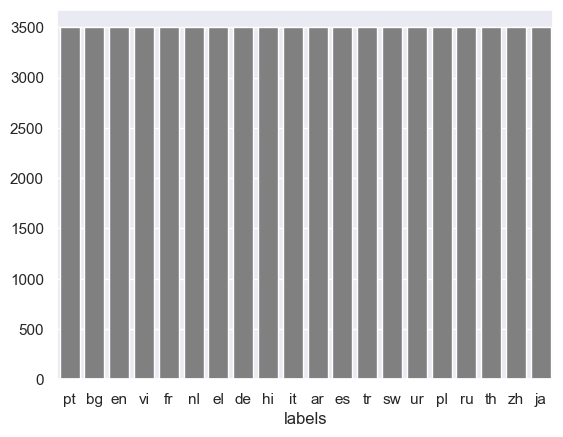

In [ ]:
import seaborn as sns
sns.set()
sns.barplot(dfTrain['labels'].value_counts().to_frame().T, color='grey')

In [ ]:
!nvidia-smi

zsh:1: command not found: nvidia-smi


In [ ]:
from transformers import XLMRobertaTokenizer, XLMRobertaModel
tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-base')
model = XLMRobertaModel.from_pretrained("xlm-roberta-base")
tokenizer.pad_token = tokenizer.eos_token

In [ ]:
dfTrain['text']= dfTrain['text'].progress_apply(lambda x: tokenizer(x,padding=True, return_tensors='pt',truncation = True))

100%|██████████| 70000/70000 [00:18<00:00, 3800.09it/s]


In [ ]:
dfVal['text']= dfVal['text'].progress_apply(lambda x: tokenizer(x,padding=True,truncation=True, return_tensors='pt'))

100%|██████████| 10000/10000 [00:02<00:00, 3903.73it/s]


In [ ]:
dfTest['text']= dfTest['text'].progress_apply(lambda x: tokenizer(x,padding=True,truncation=True, return_tensors='pt'))


100%|██████████| 10000/10000 [00:03<00:00, 3216.50it/s]


In [ ]:
def embed(t):
    t= {key: value.to('cuda') for key, value in t.items()}
    with torch.no_grad():
        outputs = model(**t)
        last_hidden_state = outputs.last_hidden_state
        cls_embeddings = last_hidden_state[:, 0,]
    return cls_embeddings

In [ ]:
dfTrain['embed']= dfTrain['text'].progress_apply(lambda x: embed(x))

100%|██████████| 70000/70000 [10:48<00:00, 107.90it/s]


In [ ]:
dfTest['embed']= dfTest['text'].progress_apply(lambda x: embed(x))

100%|██████████| 10000/10000 [01:29<00:00, 112.03it/s]


In [ ]:
dfVal['embed']= dfVal['text'].progress_apply(lambda x: embed(x))

100%|██████████| 10000/10000 [01:29<00:00, 111.84it/s]


In [ ]:
dfTest.iloc[4,:]

labels                                                   ar
text      منحدر يواجه العديد من النقاشات المتجهه إزاء ال...
Name: 4, dtype: object

In [ ]:
!nvidia-smi

Sat May 18 23:56:07 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       On  | 00000000:00:04.0 Off |                    0 |
| N/A   76C    P0              40W /  70W |   1384MiB / 15360MiB |      8%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--